In [73]:
import pandas as pd
import numpy as np
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [74]:
stations_df = pd.read_pickle('../../Dataset/MyMethod/DailyStations_Interpolated.pkl')
stations_df.head()

,Station_Name,Transactions
0,BOULDER / JUNCTION ST1,Energy__kWh_ Year Month W...
1,BOULDER / ALPINE ST1,Energy__kWh_ Year Month ...
2,BOULDER / BASELINE ST1,Energy__kWh_ Year Month ...
3,BOULDER / FACILITIES ST1,Energy__kWh_ Year Month ...
4,COMM VITALITY / 1500PEARL2,Energy__kWh_ Year Month W...


In [75]:
stations_df.loc[0,'Transactions'].columns

Index(['Energy__kWh_', 'Year', 'Month', 'Weekday', 'Maximum T', 'Minimum T',
       'Precipitation', 'Snow', 'Charging_Time_min',
       'Remaining_Park_After_Charge_(min)'],
      dtype='object')

## **Preprocessing**

Split Train and Test Set

In [76]:
sep = int(len(stations_df)*0.85)

stations_train = stations_df[:sep]
stations_test = stations_df[sep:]

print('The Train Dataset contains', len(stations_train), 'stations')
print('The Test Dataset contains', len(stations_test), 'stations')

The Train Dataset contains 33 stations
The Test Dataset contains 6 stations


In [77]:
stations_test.head(5)

,Station_Name,Transactions
33,MUNICIPAL SC / 1000WALNUT1,Energy__kWh_ Year Month ...
34,MUNICIPAL SC / 1100WALNUT1,Energy__kWh_ Year Month ...
35,MUNICIPAL SC / 1104 SPRUCE1,Energy__kWh_ Year Month ...
36,MUNICIPAL SC / 1400 WALNUT1,Energy__kWh_ Year Month ...
37,MUNICIPAL SC / 1000WALNUT2,Energy__kWh_ Year Month ...


### **One Hot Encode**

In [78]:
# List of all months and weekdays
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


def one_hot_encode(row, months_col, weekdays_col):

    # Set all month and weekday columns to 0
    row[months_col + weekdays_col] = 0

    # Set values for months
    for month in months_col:
        row.loc[row['Month'] == month, month] = 1

    # Set values for weekdays
    for weekday in weekdays_col:
        row.loc[row['Weekday'] == weekday, weekday] = 1

    return row


stations_train['Transactions'] = stations_train['Transactions'].apply(lambda row: one_hot_encode(row, months, weekdays))
stations_test['Transactions'] = stations_test['Transactions'].apply(lambda row: one_hot_encode(row, months, weekdays))

In [79]:
stations_train.loc[0,'Transactions'].head()

,Energy__kWh_,Year,Month,Weekday,Maximum T,Minimum T,Precipitation,Snow,Charging_Time_min,Remaining_Park_After_Charge_(min),January,February,March,April,May,June,July,August,September,October,November,December,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2018-01-01,6.5040,2018.0,January,Monday,30.0,12.0,0.0,0.0,122.733333,0.300,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018-01-02,17.5270,2018.0,January,Tuesday,92.0,24.0,0.0,0.0,245.183333,331.730,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2018-01-03,18.8735,2018.0,January,Wednesday,98.0,36.0,0.0,0.0,265.083333,378.365,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-01-04,20.2200,2018.0,January,Thursday,104.0,48.0,0.0,0.0,284.983333,425.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-05,15.2220,2018.0,January,Friday,82.0,39.0,0.0,0.0,242.766667,306.235,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### **Create Sequences for Train and Test Set**

In [80]:
# Assuming 'Transactions' is a DataFrame, use the .columns attribute to get the list of columns
features = stations_df.loc[0, 'Transactions'].columns.to_list()
features_to_remove = ['Month', 'Weekday', 'Year', 'Charging_Time_min', 'Remaining_Park_After_Charge_(min)']

# Remove the specified columns
features = [feature for feature in features if feature not in features_to_remove]

print(features)

['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [81]:
X_train = [] # Array with every mini trajectory input init
Y_train = [] # 1D Array with the target Energy__kWh_
T = 14 # Time window
D = len(features) # Number of dimensions

for group_df in stations_train['Transactions']:
    group_df = group_df[features]

    for t in range(0, len(group_df) - T):
        X_train.append(group_df.iloc[t:t+T])
        Y_train.append(group_df.iloc[t+T][['Energy__kWh_','Maximum T', 'Minimum T', 'Precipitation', 'Snow']])


N = len(X_train)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train.shape, Y_train.shape

((47717, 14, 24), (47717, 5))

In [82]:
X_test = [] #Array with every mini trajectory input init
Y_test = [] #1D Array with the targets energy

for group_df in stations_test['Transactions']:
    group_df = group_df[features]

    for t in range(0,len(group_df) - T):
        X_test.append(group_df.iloc[t:t+T])
        Y_test.append(group_df.iloc[t+T][['Energy__kWh_','Maximum T', 'Minimum T', 'Precipitation', 'Snow']])


N = len(X_test)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test.shape, Y_test.shape

((1004, 14, 24), (1004, 5))

### **Scalling the Numerical columns**

Scaling the X_train and Y_train

In [83]:
# We scale also with MinMaxScaler this columns ['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow']
numerical_D = len(['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow'])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# ----------------------
#    SCALE THE X_train
# ----------------------

# Extract the first 5 columns from X_train
X_train_subset = X_train[:, :, :numerical_D]

# Reshape the subset to 2D array
X_train_subset_2d = X_train_subset.reshape(-1, numerical_D)

# Fit the scaler on the subset and transform it
x_scaler = scaler.fit_transform(X_train_subset_2d)

# Reshape the scaled subset back to the original shape
X_train_scaled_subset = x_scaler.reshape(X_train.shape[0], X_train.shape[1], numerical_D)

# Combine the scaled subset with the remaining columns of X_train
X_train_scaled = np.concatenate([X_train_scaled_subset, X_train[:, :, 5:]], axis=-1)


# ----------------------
#    SCALE THE Y_train
# ----------------------

# Reshape the subset to 2D array
Y_train_reshaped = Y_train.reshape(-1, numerical_D)

# Use the previously fitted scaler to transform the Y_train_reshaped
Y_train_scaled = scaler.transform(Y_train_reshaped)

# Keep only the energy column (target) in the Y_train_scaled
Y_train_scaled = Y_train_scaled[:,:1]

print("scaled X_train shape:", X_train_scaled.shape)
print("scaled Y_train shape:", Y_train_scaled.shape)

scaled X_train shape: (47717, 14, 24)
scaled Y_train shape: (47717, 1)


Scaling the Y_train and Y_test accord to X_train MinMaxScaler

In [84]:
# ----------------------
#    SCALE THE X_test with the fitted scaler of X_train
# ----------------------

# Extract the first 5 columns from X_test
X_test_subset = X_test[:, :, :numerical_D]

# Reshape the subset to 2D array
X_test_reshaped = X_test_subset.reshape(-1, numerical_D)

# Scaling 
X_test_scaled_subset = scaler.transform(X_test_reshaped)

X_test_scaled_subset = X_test_scaled_subset.reshape(X_test.shape[0], X_test.shape[1], numerical_D)

# Combine the scaled subset with the remaining columns of X_test
X_test_scaled = np.concatenate([X_test_scaled_subset, X_test[:, :, 5:]], axis=-1)

# ----------------------
#    SCALE THE Y_test
# ----------------------

# Reshape the subset to 2D array
Y_test_reshaped = Y_test.reshape(-1, numerical_D)

# Use the previously fitted scaler to transform the Y_test_reshaped
Y_test_scaled = scaler.transform(Y_test_reshaped)

# Keep only the energy column (target) in the Y_test_scaled
Y_test_scaled = Y_test_scaled[:,:1]

print("scaled X_test shape:", X_test_scaled.shape)
print("scaled Y_test shape:", Y_test_scaled.shape)

scaled X_test shape: (1004, 14, 24)
scaled Y_test shape: (1004, 1)


### **Build the BiGRU Model**

**loss function**

In [85]:
def root_mean_squared_error(y_true, y_pred):
        return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)) + 1e-9)

**Model Architecture**

In [86]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(24,activation= 'relu', recurrent_dropout= 0.1, kernel_regularizer= 'l2')),   
        tf.keras.layers.Dense(1),
    ]
)

model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1, clipvalue=1.0))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 48)               7200      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 49        
                                                                 
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
_________________________________________________________________


**learning rate schedule**

In [87]:
def lr_schedule(epoch):
    initial_lr = 0.01
    drop = 0.5 
    epochs_drop = 7

    lr = initial_lr * (drop ** (epoch // epochs_drop))
    
    return lr

#This means that the lr drops at half every 7 epochs.

lr_scheduler = LearningRateScheduler(lr_schedule)

**Train the model**

In [88]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(
    x = X_train_scaled,
    y = Y_train_scaled,
    epochs=250,
    batch_size= 16,
    callbacks=[lr_scheduler,early_stop],
    verbose=1,
    validation_data=(X_test_scaled,Y_test_scaled)
)

Epoch 1/250
2983/2983 [==============================] - 50s 15ms/step - loss: 0.0749 - val_loss: 0.0785 - lr: 0.0100
Epoch 2/250
2983/2983 [==============================] - 44s 15ms/step - loss: 0.0706 - val_loss: 0.0831 - lr: 0.0100
Epoch 3/250
2983/2983 [==============================] - 44s 15ms/step - loss: 0.0702 - val_loss: 0.0806 - lr: 0.0100
Epoch 4/250
2983/2983 [==============================] - 51s 17ms/step - loss: 0.0702 - val_loss: 0.1019 - lr: 0.0100
Epoch 5/250
2983/2983 [==============================] - 47s 16ms/step - loss: 0.0701 - val_loss: 0.0795 - lr: 0.0100
Epoch 6/250
2983/2983 [==============================] - 50s 17ms/step - loss: 0.0705 - val_loss: 0.0835 - lr: 0.0100
Epoch 7/250
2983/2983 [==============================] - 46s 15ms/step - loss: 0.0696 - val_loss: 0.0783 - lr: 0.0100
Epoch 8/250
2983/2983 [==============================] - 46s 15ms/step - loss: 0.0669 - val_loss: 0.0794 - lr: 0.0050
Epoch 9/250
2983/2983 [==============================] -

In [108]:
# Save entire model
model.save('../My_Method_perStations/entire_BiGRUmodel.h5')

### **Evaluate the Model**

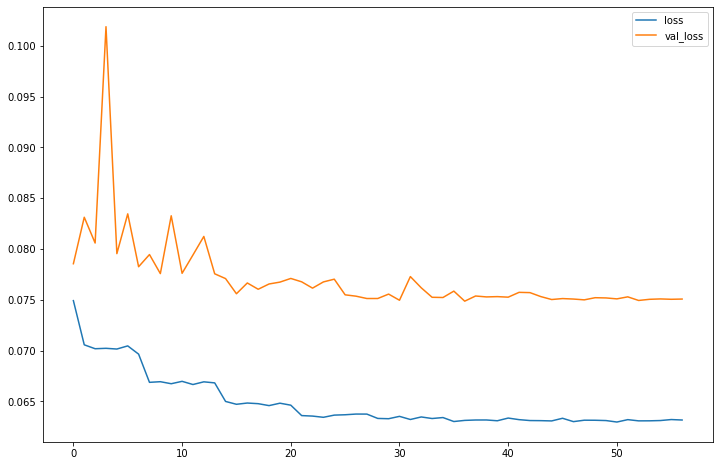

In [90]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label= 'loss')
plt.plot(history.history['val_loss'], label= 'val_loss')
plt.legend()
plt.show()

In [91]:
# Source: https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9/revisions

def calculate_nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    return nrmse

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Generate predictions using the model
y_pred = model(X_test_scaled)

# Inverse transform the scaled predictions to the original scale
inversed_y_pred = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], numerical_D-1))], axis=1))
inversed_y_pred = inversed_y_pred[:, 0]

# Assuming y_pred and inversed_y_pred are NumPy arrays
inversed_y_pred_tensor = tf.convert_to_tensor(inversed_y_pred, dtype=tf.float32)

# Calculate RMSE
rmse = calculate_rmse(Y_test[:, 0], inversed_y_pred)

# Calculate NRMSE
nrmse = calculate_nrmse(Y_test[:, 0], inversed_y_pred)

# Calculate MAE
mae= calculate_mae(Y_test[:, 0], inversed_y_pred)


# Print the results
print(f"RMSE: {rmse}")
print(f"NRMSE: {nrmse}")
print(f'MAE: {mae}')

RMSE: 15.611618801261278
NRMSE: 0.14589070826997055
MAE: 11.220106673155989


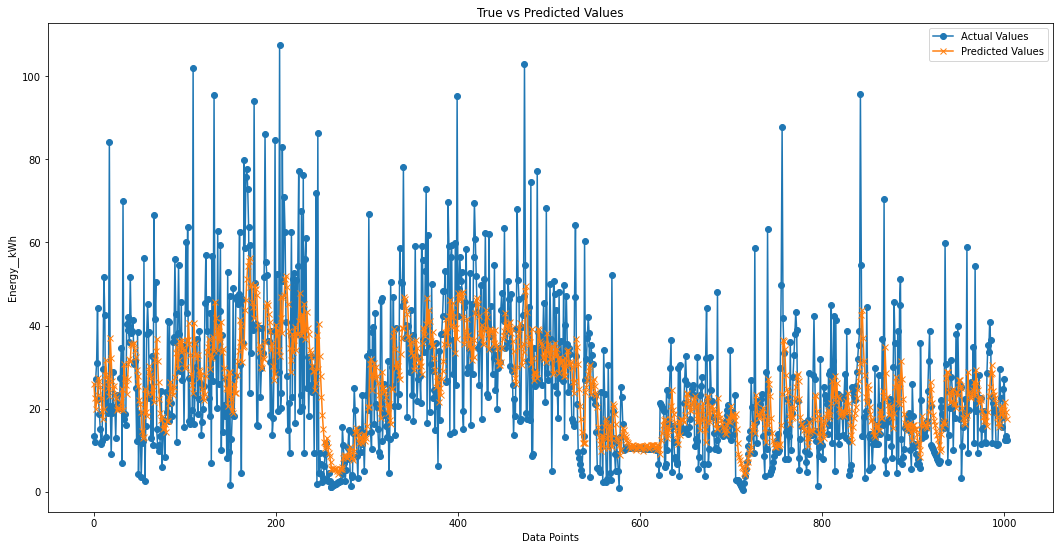

In [92]:
plt.figure(figsize=(18,9))

# Plotting true values
plt.plot(Y_test[:, 0], label='Actual Values', marker='o')

# Plotting predicted values
plt.plot(inversed_y_pred, label='Predicted Values', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Energy__kWh')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

### **Make a Prediction  |  One-Step Forecast**

1/1 [==============================] - 1s 709ms/step


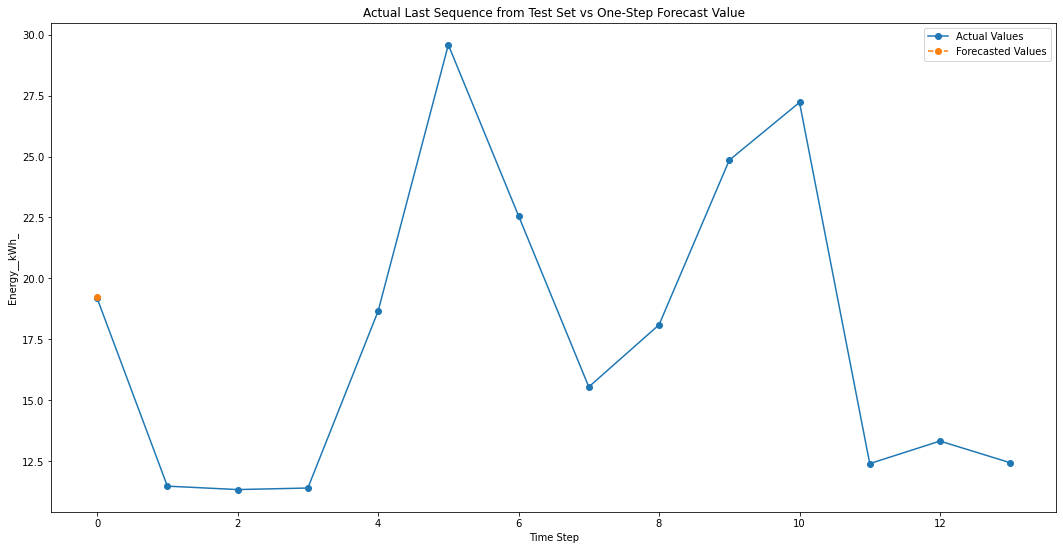

The actual value we need to predict is 19.185 kWh
The foreast value is 19.222 kWh


In [93]:
# Extract the last sequence from the test data for one-step forecasting
last_sequence = X_test_scaled[-2:-1].reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])

# Make a one-step forecast
one_step_forecast_scaled = model.predict(last_sequence)

# Inverse transform
one_step_forecast = scaler.inverse_transform(np.concatenate([one_step_forecast_scaled, np.zeros((one_step_forecast_scaled.shape[0], numerical_D-1))], axis=1))
one_step_forecast = one_step_forecast[0, 0]

# Assuming Y_test and y_true are NumPy arrays
y_true = Y_test[-T:, 0]

# Plotting the results
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='Actual Values', marker='o')
plt.plot(one_step_forecast, label='Forecasted Values', linestyle='dashed', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Energy__kWh_')
plt.title('Actual Last Sequence from Test Set vs One-Step Forecast Value')
plt.legend()
plt.show()

print('The actual value we need to predict is', Y_test[-T, 0], 'kWh')
print('The foreast value is' ,np.round(one_step_forecast,3), 'kWh')

### **Make Predictions  |  Multi-Step Forecast**

**First we implement small examples how we fill the last observations in the sequence for each forecasting step**

**Columns of numpy array**

In [94]:
# Print the column names for X_train_scaled
print("Column names for X_train_scaled:")
print(features)

Column names for X_train_scaled:
['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


**One Hot Encode Manually for the Days**

In [95]:
# Print the column names for X_train_scaled
print("Column names of the Months for X_train_scaled:")
print(features[17:])

Column names of the Months for X_train_scaled:
['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [96]:
last_sequence = X_test_scaled[-2:-1].copy()
X_forecast = last_sequence.reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])

# Update the last observations for Weekday columns
for _ in range(7):
    # Find the currect day in one hot array (find the 1)
    current_index = X_forecast[0, -1, 17:].argmax()

    # Update the next value (go forward a day)
    next_index = (current_index + 1) % len(X_forecast[0, -1, 17:])
    print('Previous form :', X_forecast[0, -1, 17:])
    X_forecast[0, -1, 17:] = 0
    X_forecast[0, -1, 17:][next_index] = 1
    print('Next form :    ', X_forecast[0, -1, 17:], '\n')

Previous form : [0. 1. 0. 0. 0. 0. 0.]
Next form :     [0. 0. 1. 0. 0. 0. 0.] 

Previous form : [0. 0. 1. 0. 0. 0. 0.]
Next form :     [0. 0. 0. 1. 0. 0. 0.] 

Previous form : [0. 0. 0. 1. 0. 0. 0.]
Next form :     [0. 0. 0. 0. 1. 0. 0.] 

Previous form : [0. 0. 0. 0. 1. 0. 0.]
Next form :     [0. 0. 0. 0. 0. 1. 0.] 

Previous form : [0. 0. 0. 0. 0. 1. 0.]
Next form :     [0. 0. 0. 0. 0. 0. 1.] 

Previous form : [0. 0. 0. 0. 0. 0. 1.]
Next form :     [1. 0. 0. 0. 0. 0. 0.] 

Previous form : [1. 0. 0. 0. 0. 0. 0.]
Next form :     [0. 1. 0. 0. 0. 0. 0.] 



**One Hot Encode Manually for the Months**

In [97]:
# Print the column names for X_train_scaled
print("Column names of the Months for X_train_scaled:")
print(features[5:17])

Column names of the Months for X_train_scaled:
['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [98]:
last_sequence = X_test_scaled[-2:-1].copy()
X_forecast = last_sequence.reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])

for i in range(4):
    current_day = 20 # you need to provide like the date of days
    year = 2022
    current_month_index = np.argmax(X_forecast[0, -1, 5:17])
    
    for j in range(30):
        _, days_in_current_month = calendar.monthrange(year, current_month_index + 1)

        if current_day == days_in_current_month:
            # Update the next month
            next_month_index = (current_month_index + 1) % len(X_forecast[0, -1, 5:17])
            print('For the', i, 'loop we change the month in day', current_day, 'and the previous month was ', current_month_index + 1)
            print('Previous form :', X_forecast[0, -1, 5:17])
            X_forecast[0, -1, 5:17] = 0
            X_forecast[0, -1, 5:17][next_month_index] = 1
            print('Next form :    ', X_forecast[0, -1, 5:17], '\n')

            break
            
        current_day += 1

For the 0 loop we change the month in day 30 and the previous month was  11
Previous form : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Next form :     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 

For the 1 loop we change the month in day 31 and the previous month was  12
Previous form : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Next form :     [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

For the 2 loop we change the month in day 31 and the previous month was  1
Previous form : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Next form :     [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

For the 3 loop we change the month in day 28 and the previous month was  2
Previous form : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Next form :     [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 



**Update the Numerical Columns for the Next Forecast**

In [99]:
# Print the column names for X_train_scaled
print("Column names of the Months for X_train_scaled:")
print(features[:5])

Column names of the Months for X_train_scaled:
['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow']


**Update the Numeric Columns with Means for Forecasting**

In [100]:
last_sequence = X_test_scaled[-2:-1].copy()
X_forecast = last_sequence.reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])

for _ in range(4):
    print('Previous form :', X_forecast[0, -1, :5])
    # Maximum T
    X_forecast[0, -1, 1] = np.mean(X_forecast[0, :, 1]) 

    # Minimum T
    X_forecast[0, -1, 2] = np.mean(X_forecast[0, :, 2])

    # Precipitation
    X_forecast[0, -1, 3] = np.mean(X_forecast[0, :, 3])

    # Snow
    X_forecast[0, -1, 4] = np.mean(X_forecast[0, :, 4])
    print('Next form :    ', X_forecast[0, -1, :5], '\n')

Previous form : [0.06292344 0.0406639  0.10897436 0.         0.        ]
Next form :     [0.06292344 0.08197985 0.13846917 0.00568124 0.02108096] 

Previous form : [0.06292344 0.08197985 0.13846917 0.00568124 0.02108096]
Next form :     [0.06292344 0.08493098 0.14057594 0.00608704 0.02258674] 

Previous form : [0.06292344 0.08493098 0.14057594 0.00608704 0.02258674]
Next form :     [0.06292344 0.08514178 0.14072643 0.00611603 0.0226943 ] 

Previous form : [0.06292344 0.08514178 0.14072643 0.00611603 0.0226943 ]
Next form :     [0.06292344 0.08515684 0.14073717 0.0061181  0.02270198] 



**Update the Numeric Columns with Perturbed Means for Forecasting**

In [101]:
last_sequence = X_test_scaled[-2:-1].copy()
X_forecast = last_sequence.reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])

for _ in range(4):
    print('Previous form :', X_forecast[0, -1, :5])

    # Maximum T
    max_temp_mean = np.mean(X_forecast[0, :, 1])
    X_forecast[0, -1, 1] = np.abs(max_temp_mean + np.random.normal(scale=0.1))

    # Minimum T
    min_temp_mean = np.mean(X_forecast[0, :, 2])
    X_forecast[0, -1, 2] = np.abs(min_temp_mean + np.random.normal(scale=0.1))

    # Precipitation
    precip_mean = np.mean(X_forecast[0, :, 3])
    X_forecast[0, -1, 3] = np.abs(precip_mean + np.random.normal(scale=0.01))

    # Snow
    snow_mean = np.mean(X_forecast[0, :, 4])
    X_forecast[0, -1, 4] = np.abs(snow_mean + np.random.normal(scale=0.01))

    print('Next form :    ', X_forecast[0, -1, :5], '\n')

Previous form : [0.06292344 0.0406639  0.10897436 0.         0.        ]
Next form :     [0.06292344 0.1653982  0.05714543 0.00489638 0.0183632 ] 

Previous form : [0.06292344 0.1653982  0.05714543 0.00489638 0.0183632 ]
Next form :     [0.06292344 0.11748076 0.13053055 0.00461679 0.00740343] 

Previous form : [0.06292344 0.11748076 0.13053055 0.00461679 0.00740343]
Next form :     [0.06292344 0.11379039 0.1315877  0.00472326 0.02537305] 

Previous form : [0.06292344 0.11379039 0.1315877  0.00472326 0.02537305]
Next form :     [0.06292344 0.20527716 0.2169046  0.00352409 0.03096598] 



### **Now let's implement all this in a function to make a MultiStep Forecasting**

**We need at first to extract the date of the specific sequence to give as valid information we can in the BiGRU model**

In [102]:
def extract_month_weekday_drom_sequence(sequence):
    sequence_with_last_weekday = sequence[:, -1, 17:]
    last_weekday_of_sequence = np.argmax(sequence_with_last_weekday)

    sequence_with_last_month = sequence[:, -1, 5:17]
    last_month_of_sequence = np.argmax(sequence_with_last_month) + 1

    return last_weekday_of_sequence, last_month_of_sequence


def extract_srt_date(year, month, weekday):
    # Find the last day of the month
    last_day = calendar.monthrange(year, month)[1]
    
    # Find the weekday of the last day
    last_day_weekday = calendar.weekday(year, month, last_day)
    
    # Calculate the difference between the desired weekday and the last day's weekday
    difference = (last_day_weekday - weekday + 7) % 7
    
    # Calculate the date of the last specified weekday
    last_weekday_date = last_day - difference
    
    return f"{year}-{month:02d}-{last_weekday_date:02d}"


def extract_date_info(date_str):
    # Convert the string to a datetime object
    date_object = dt.strptime(date_str, '%Y-%m-%d')  # Assuming the date format is 'YYYY-MM-DD'

    # Extract day, month, and year as integers
    day = date_object.day
    month = date_object.month
    year = date_object.year

    return day, month, year

**Example how it works**

In [103]:
last_sequence = X_test_scaled[-2:-1].copy()

month, weekday = extract_month_weekday_drom_sequence(last_sequence)
print('As we see the station_test contains only one year :', *stations_test.loc[37,'Transactions']['Year'].unique())
print('The last Month is :', month)
print('The last Weekday is :', weekday, '\n')

year = 2023
specific_date = extract_srt_date(year, month, weekday)
print(f"The last Date of sequence is on {specific_date}")
print('If we check on 28 November 2023 the weekday is Tuesday like our sequence :', last_sequence[:, -1, 17:],'\n')

day, month, year = extract_date_info(specific_date)
print(f'Day: {day}')
print(f'Month: {month}')
print(f'Year: {year}')

As we see the station_test contains only one year : 2023.0
The last Month is : 1
The last Weekday is : 11 

The last Date of sequence is on 2023-01-27
If we check on 28 November 2023 the weekday is Tuesday like our sequence : [[0. 1. 0. 0. 0. 0. 0.]] 

Day: 27
Month: 1
Year: 2023


**Forecast function with means method**

In [104]:
def Forecasting(last_sequence, window_size, n_features, year, num_forecasts):
    # Reshape the last sequence in X_test_scaled for forecasting
    X_forecast = last_sequence.reshape(1, window_size, n_features)

    # Extract the Start Date of Forecast
    month, weekday = extract_month_weekday_drom_sequence(last_sequence)
    specific_date = extract_srt_date(year, month, weekday)
    current_day, current_month_index, year = extract_date_info(specific_date)

    # Generate the forecasts
    Forecast = np.zeros((num_forecasts, 1), dtype=float)  # Initialize an empty NumPy array

    for i in range(num_forecasts):
        next_value = model.predict(X_forecast)
        Forecast[i, 0] = next_value  # Store the predicted value in the NumPy array

        # Update X_forecast for the next prediction
        X_forecast = np.roll(X_forecast, -1, axis=1) # Take the first row of sequence and add to the end to drop it
        X_forecast[0, -1, 0] = next_value  # Update the last value in the sequence with the predicted value

        # Update days
        current_index = X_forecast[0, -1, 17:].argmax()
        next_index = (current_index + 1) % len(X_forecast[0, -1, 17:])
        X_forecast[0, -1, 17:] = 0
        X_forecast[0, -1, 17:][next_index] = 1

        # Update months
        _, days_in_current_month = calendar.monthrange(year, current_month_index + 1)

        if current_day == days_in_current_month:
            next_month_index = (current_month_index + 1) % len(X_forecast[0, -1, 5:17])
            X_forecast[0, -1, 5:17] = 0
            X_forecast[0, -1, 5:17][next_month_index] = 1
        
        current_day += 1

        # Update numeric columns
        X_forecast[0, -1, 1] = np.mean(X_forecast[0, :, 1])
        X_forecast[0, -1, 2] = np.mean(X_forecast[0, :, 2])
        X_forecast[0, -1, 3] = np.mean(X_forecast[0, :, 3])
        X_forecast[0, -1, 4] = np.mean(X_forecast[0, :, 4])

    return Forecast


last_sequence = X_test_scaled[-2:-1].copy()
window_size = T
n_features = X_test_scaled.shape[2]
year = 2023 
num_forecasts = T

Forecast_scaled = Forecasting(last_sequence , window_size, n_features, year, num_forecasts)
Forecast = scaler.inverse_transform(np.concatenate([Forecast_scaled, np.zeros((Forecast_scaled.shape[0], numerical_D-1))], axis=1))
Forecast_energy_values = Forecast[:,0]

# Print the pairs
print('The Forecasted values and Actual values are:')
for forecast, actual in zip(np.round(Forecast_energy_values, 3), Y_test[-T:, 0]):
    print(f'Forecasted: {forecast}, Actual: {actual}')


# Calculate RMSE
rmse = calculate_rmse(Y_test[-T:, 0], Forecast_energy_values)

# Calculate NRMSE
nrmse = calculate_nrmse(Y_test[-T:, 0], Forecast_energy_values)

# Calculate MAE
mae= calculate_mae(Y_test[-T:, 0], Forecast_energy_values)


# Print the results
print(f"RMSE: {rmse}")
print(f"NRMSE: {nrmse}")
print(f'MAE: {mae}')

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 30ms/step
The Forecasted values and Actual values are:
Forecasted: 19.222, Actual: 19.185
Forecasted: 19.247, Actual: 11.475
Forecasted: 18.761, Actual: 11.335
Forecasted: 18.076, Actual: 11.398
Forecasted: 18.304, Actual: 18.654
Forecasted: 18.667, Actual: 29.587
Forecasted: 18.659, Actual: 22.567
Forecasted: 18.621, Actual: 15.547
Forecasted: 18.706, Actual: 18.096
Forecasted: 18.219, Actual: 24.853
Forecasted: 17.578, Actual: 27.223
Forecasted: 17.84, Actual: 12.4
Forecasted: 18.214, Actual: 13.325
Forecasted: 18.189, Actual: 12.436
RMSE: 6.142428724974449
NRMSE: 0.33653455648556047
MAE: 5.223789422179971


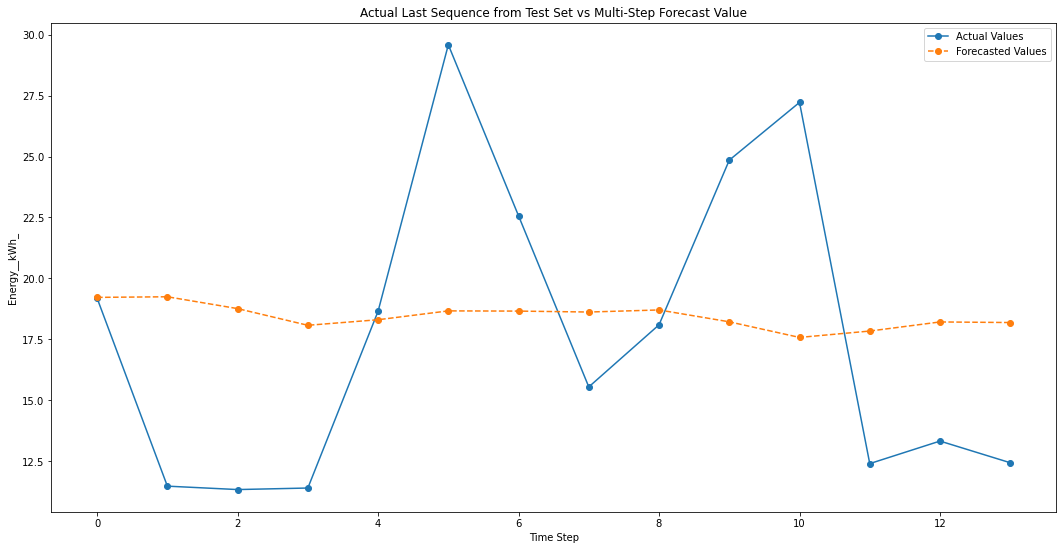

In [105]:
# Assuming Y_test and y_true are NumPy arrays
y_true = Y_test[-T:, 0]

# Plotting the results
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='Actual Values', marker='o')
plt.plot(Forecast_energy_values, label='Forecasted Values', linestyle='dashed', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Energy__kWh_')
plt.title('Actual Last Sequence from Test Set vs Multi-Step Forecast Value')
plt.legend()
plt.show()

**Forecast function with perturbed means method**

In [106]:
def Forecasting(last_sequence, window_size, n_features, year, num_forecasts):
    # Reshape the last sequence in X_test_scaled for forecasting
    X_forecast = last_sequence.reshape(1, window_size, n_features)

    # Extract the Start Date of Forecast
    month, weekday = extract_month_weekday_drom_sequence(last_sequence)
    specific_date = extract_srt_date(year, month, weekday)
    current_day, current_month_index, year = extract_date_info(specific_date)

    # Generate the forecasts
    Forecast = np.zeros((num_forecasts, 1), dtype=float)  # Initialize an empty NumPy array

    for i in range(num_forecasts):
        next_value = model.predict(X_forecast)
        Forecast[i, 0] = next_value  # Store the predicted value in the NumPy array

        # Update X_forecast for the next prediction
        X_forecast = np.roll(X_forecast, -1, axis=1) # Take the first row of sequence and add to the end to drop it
        X_forecast[0, -1, 0] = next_value  # Update the last value in the sequence with the predicted value

        # Update days
        current_index = X_forecast[0, -1, 17:].argmax()
        next_index = (current_index + 1) % len(X_forecast[0, -1, 17:])
        X_forecast[0, -1, 17:] = 0
        X_forecast[0, -1, 17:][next_index] = 1

        # Update months
        _, days_in_current_month = calendar.monthrange(year, current_month_index + 1)

        if current_day == days_in_current_month:
            next_month_index = (current_month_index + 1) % len(X_forecast[0, -1, 5:17])
            X_forecast[0, -1, 5:17] = 0
            X_forecast[0, -1, 5:17][next_month_index] = 1
        
        current_day += 1

        # Update numeric columns
        # Maximum T
        max_temp_mean = np.mean(X_forecast[0, :, 1])
        X_forecast[0, -1, 1] = np.abs(max_temp_mean + np.random.normal(scale=0.1))
        # Minimum T
        min_temp_mean = np.mean(X_forecast[0, :, 2])
        X_forecast[0, -1, 2] = np.abs(min_temp_mean + np.random.normal(scale=0.1))
        # Precipitation
        precip_mean = np.mean(X_forecast[0, :, 3])
        X_forecast[0, -1, 3] = np.abs(precip_mean + np.random.normal(scale=0.01))
        # Snow
        snow_mean = np.mean(X_forecast[0, :, 4])
        X_forecast[0, -1, 4] = np.abs(snow_mean + np.random.normal(scale=0.01))

    return Forecast


last_sequence = X_test_scaled[-2:-1].copy()
window_size = T
n_features = X_test_scaled.shape[2]
year = 2023 
num_forecasts = T

Forecast_scaled = Forecasting(last_sequence , window_size, n_features, year, num_forecasts)
Forecast = scaler.inverse_transform(np.concatenate([Forecast_scaled, np.zeros((Forecast_scaled.shape[0], numerical_D-1))], axis=1))
Forecast_energy_values = Forecast[:,0]

# Print the pairs
print('The Forecasted values and Actual values are:')
for forecast, actual in zip(np.round(Forecast_energy_values, 3), Y_test[-T:, 0]):
    print(f'Forecasted: {forecast}, Actual: {actual}')


# Calculate RMSE
rmse = calculate_rmse(Y_test[-T:, 0], Forecast_energy_values)

# Calculate NRMSE
nrmse = calculate_nrmse(Y_test[-T:, 0], Forecast_energy_values)

# Calculate MAE
mae= calculate_mae(Y_test[-T:, 0], Forecast_energy_values)


# Print the results
print(f"RMSE: {rmse}")
print(f"NRMSE: {nrmse}")
print(f'MAE: {mae}')

1/1 [==============================] - 0s 31ms/step
The Forecasted values and Actual values are:
Forecasted: 19.222, Actual: 19.185
Forecasted: 19.684, Actual: 11.475
Forecasted: 19.874, Actual: 11.335
Forecasted: 19.334, Actual: 11.398
Forecasted: 19.571, Actual: 18.654
Forecasted: 20.317, Actual: 29.587
Forecasted: 20.811, Actual: 22.567
Forecasted: 20.61, Actual: 15.547
Forecasted: 20.115, Actual: 18.096
Forecasted: 19.52, Actual: 24.853
Forecasted: 19.896, Actual: 27.223
Forecasted: 20.568, Actual: 12.4
Forecasted: 20.979, Actual: 13.325
Forecasted: 20.914, Actual: 12.436
RMSE: 6.558240178139855
NRMSE: 0.3593162490762577
MAE: 5.7646762396267475


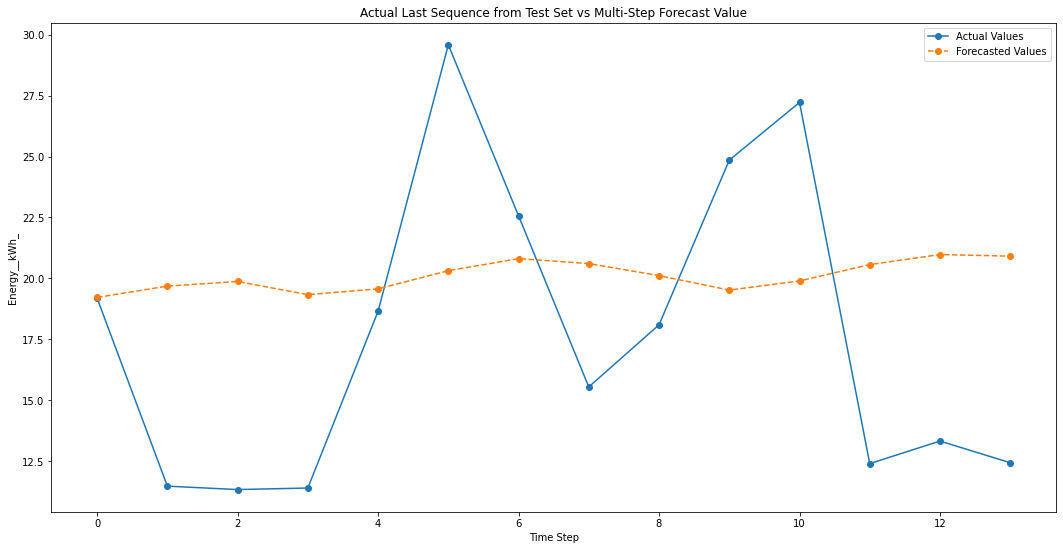

In [107]:
# Assuming Y_test and y_true are NumPy arrays
y_true = Y_test[-T:, 0]

# Plotting the results
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='Actual Values', marker='o')
plt.plot(Forecast_energy_values, label='Forecasted Values', linestyle='dashed', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Energy__kWh_')
plt.title('Actual Last Sequence from Test Set vs Multi-Step Forecast Value')
plt.legend()
plt.show()